In [1]:
import os
import os.path as osp

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import yaml
from attrdict import AttrDict
from tqdm.notebook import tqdm

from regression.models.ipnp import IPNP
from regression.gp import GPSampler, RBFKernel
from regression.utils.misc import load_module

plt.rcParams['figure.facecolor'] = 'white'

In [2]:
seed = 2
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [3]:
def load_model(model_name, min_ctx, device):
    repo_dir = '/share/kuleshov/yzs2/TNP-pytorch/'
    exp_category = 'regression'
    exp = 'gp'
    v = 'v0'
    args_file = 'args.yaml'
    results_dir = osp.join(repo_dir, exp_category, 'results', exp, f'ctx-{min_ctx}-{min_ctx*2}_tar-4-64')
    with open(osp.join(results_dir, model_name, v, args_file), 'r') as af:
        args_dict = yaml.safe_load(af)
        args = AttrDict(args_dict)
    
    model_cls = getattr(load_module(os.path.join(repo_dir, exp_category, 'models', f'{args.model}.py')),
                    args.model.upper())
    with open(osp.join(repo_dir, exp_category, args.root, 'config.yaml'), 'r') as f:
        config = yaml.safe_load(f)
    
    model = model_cls(**config)
    ckpt = torch.load(osp.join(repo_dir, exp_category, args.root, 'ckpt.tar'), map_location=device)
    model.load_state_dict(ckpt.model)
    model.eval()
    model = model.to(device)
    return model

In [4]:
def load_eval_batches(min_ctx, seed, device):
    repo_dir = '/share/kuleshov/yzs2/TNP-pytorch/'
    exp_category = 'regression'
    exp = 'gp'
    eval_dir = f'ctx-{min_ctx}-{min_ctx*2}_tar-4-64'
    eval_filename = f'rbf-seed{seed}.tar'
    return torch.load(osp.join(repo_dir, exp_category, 'evalsets', exp, eval_dir, eval_filename),
                      map_location=device)

In [5]:
def plot_preds(ax, py, xc, yc, x, y):
#     ax.plot(x, y, 'k:', linewidth=1, label='ground truth')
    ax.scatter(xc, yc, s=50, color='red', marker='o', label='ctx pts')
    py_mean = py.mean[0].cpu().squeeze().detach().numpy()
    py_std = py.scale[0].cpu().squeeze().detach().numpy()
    ax.plot(x, py_mean, label='pred mean')
    ax.fill_between(x, py_mean - py_std, py_mean + py_std,
                    alpha=0.2, label='+/- std')
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])

# Uncertainty

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_display_name = {'anp': 'ANP', 'banp': 'BANP', 'canp': 'CANP', 'ipcanp': 'CIPNP', 'ipanp': 'IPNP'}

sampler = GPSampler(RBFKernel())
main_sample = sampler.sample(batch_size=1,
                             num_ctx=4096,
                             num_tar=1,
                             device=device)
xc_argsort = torch.argsort(main_sample.xc.squeeze())

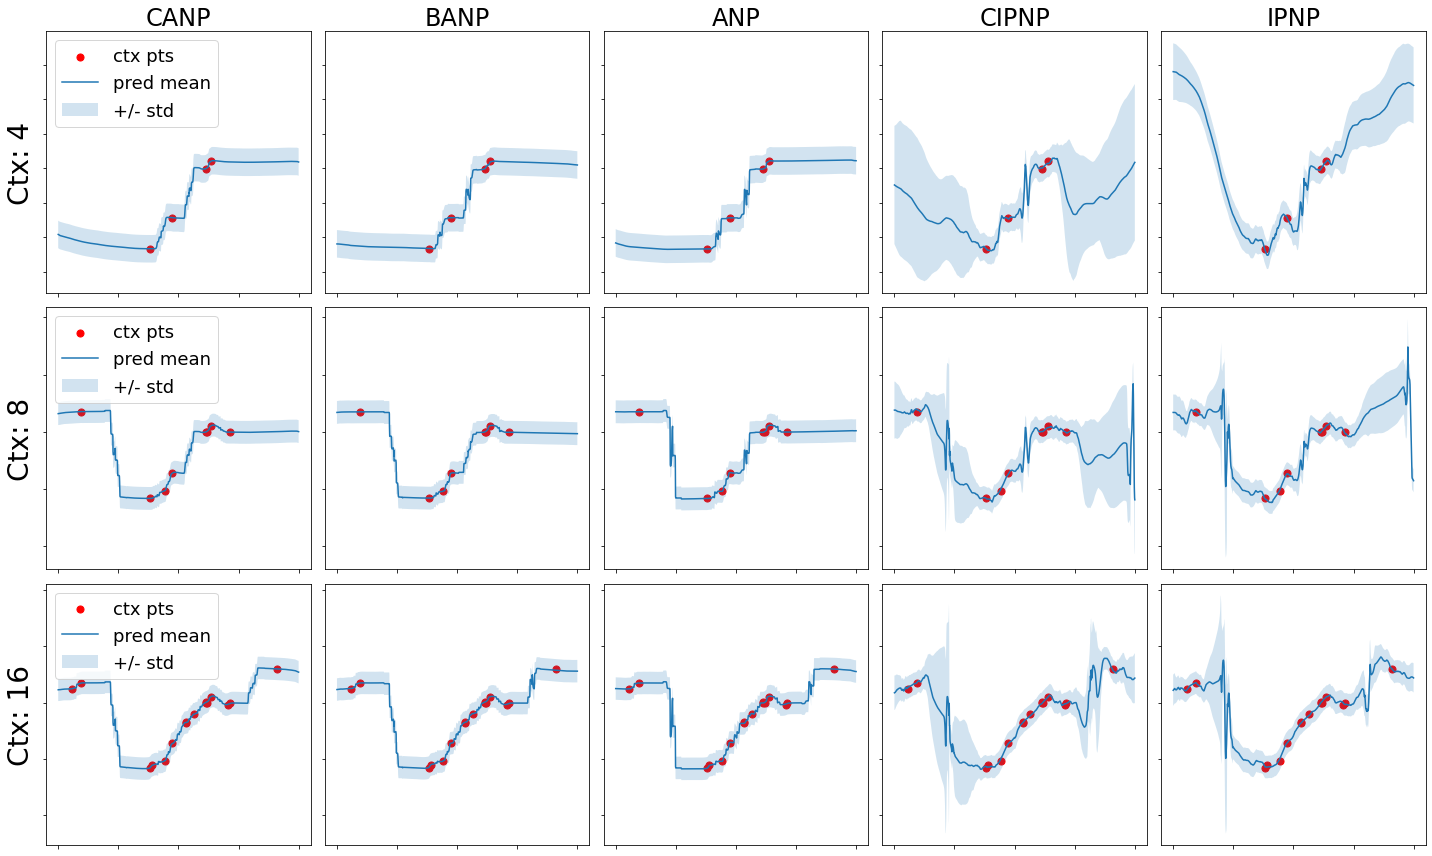

In [7]:
min_ctx_to_load = 64
model_names = ['canp', 'banp', 'anp', 'ipcanp', 'ipanp']
models = {m: load_model(model_name=m, min_ctx=min_ctx_to_load, device=device) for m in model_names}
ctxs = [4, 8, 16] #, 32, 64, 128, 256, 512, 1024]
fig, axs = plt.subplots(nrows=len(ctxs), ncols=len(models),
                        sharey='row',
                        sharex='col',
                        figsize=(4*len(models), 4*len(ctxs)),
                        tight_layout=True)
for ax, m in zip(axs[0], model_names):
    ax.set_title(model_display_name[m], fontsize=24)
for ax, c in zip(axs[:,0], ctxs):
    ax.set_ylabel(f'Ctx: {c}', rotation=90, fontsize=28)

for i, c in enumerate(ctxs):
    sample = AttrDict({k: v[:,:c,:] for k, v in main_sample.items()})
    for j, m in enumerate(model_names):
        try:
            model_py = models[m].predict(xc=sample.xc, yc=sample.yc, xt=main_sample.xc[:, xc_argsort, :])
            plot_preds(
                ax=axs[i, j], py=model_py,
                xc=sample.xc.squeeze().cpu(), yc=sample.yc.squeeze().cpu(),
                x=main_sample.xc[:, xc_argsort, :].squeeze().cpu(), y=main_sample.yc[:, xc_argsort, :].squeeze().cpu()
            )
            if m == model_names[0]:
                axs[i, j].legend(loc='upper left', fontsize=18)
        except FileNotFoundError:
            axs[i, j].text(0.5, 0, 'OOM', size=30, ha="center")
plt.show()
repo_dir = '/share/kuleshov/yzs2/TNP-pytorch/'
exp_category = 'regression'
exp = 'gp'
fig.savefig(osp.join(repo_dir, exp_category, 'results', exp, f'NP_uncertainty_ctx{min_ctx_to_load}.pdf'))
fig.savefig(osp.join(repo_dir, exp_category, 'results', exp, f'NP_uncertainty_ctx{min_ctx_to_load}.png'))
fig.savefig(osp.join(repo_dir, exp_category, 'results', exp, f'NP_uncertainty_ctx{min_ctx_to_load}.svg'))

# Calibration

In [ ]:
def get_confidence_interval(dist, ci):
    ci = ci / 100 if ci > 1 else ci
    quant_low = (1 - ci) / 2
    quant_up = 1 - 0.5 + (ci / 2)
    with torch.no_grad():        
        return dist.icdf(quant_low), dist.icdf(quant_up)

In [ ]:
def check_for_inclusion(val, ci):
    with torch.no_grad():
        return torch.le(ci[0], val) * torch.le(val, ci[1])

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
min_ctx_to_load = 64
model_display_name = {'anp': 'ANP', 'banp': 'BANP', 'canp': 'CANP', 'ipcanp': 'CIPNP', 'ipanp': 'IPNP'}
colors = {'anp': 'darkorange', 'banp': 'green', 'canp': 'red', 'ipcanp': 'dodgerblue', 'ipanp': 'blue'}
eval_batches = load_eval_batches(min_ctx=min_ctx_to_load, seed=seed, device=device)
model_names = ['canp', 'banp', 'anp', 'ipcanp', 'ipanp']
models = {m: load_model(model_name=m, min_ctx=min_ctx_to_load, device=device) for m in model_names}

In [ ]:
num_batches = 1000
ebs = [eval_batches[n] for n in np.random.choice(len(eval_batches), num_batches, replace=False)]
total_count = torch.tensor([eb.yt.numel() for eb in eval_batches[:num_batches]]).sum().item()
ctxs = [4, 8, 16]
fig, axes = plt.subplots(nrows=1, ncols=len(ctxs), figsize=(6*len(ctxs),6), tight_layout=True, sharey=True)
# fig.suptitle('NP Model Calibration', fontsize=24)
model_calib_scores = {m: {c: 0 for c in ctxs} for m in model_names}
for i, c in enumerate(ctxs):
    ax = axes[i]
    if i == 0:
        ax.set_ylabel('% of values in CI', fontsize=24)
    if i == 1:
        ax.set_xlabel('Confidence Interval (CI)', fontsize=24)
    model_y_in_cis_count = {m: [0]*len(torch.arange(0.1, 1, 0.1)) for m in model_names}
    for eb in tqdm(ebs, desc='Eval'):
        model_pys = {m: models[m].predict(xc=eb.xc[:,:c,:], yc=eb.yc[:,:c,:], xt=eb.xt)
                     for m in model_names}
        model_cis = {m: [get_confidence_interval(model_pys[m], ci) for ci in torch.arange(0.1, 1, 0.1)]
                     for m in model_names}
        model_y_in_cis = {m: [check_for_inclusion(eb.yt, ci) for ci in model_cis[m]]
                          for m in model_names}            
        for m in model_names:
            for ci in range(len(torch.arange(0.1, 1, 0.1))):
                model_y_in_cis_count[m][ci] += model_y_in_cis[m][ci].sum().item()
#         if c == 16:
#             print({m: [model_y_in_cis_count[m][ci] for ci in range(9)] for m in model_names}, '\n')
    model_calib = {m: [0] +
                   [model_y_in_cis_count[m][ci] / total_count for ci in range(len(torch.arange(0.1, 1, 0.1)))] +
                   [1.0]
                   for m in model_names}

    ax.plot(torch.arange(0, 1.1, 0.1), torch.arange(0, 1.1, 0.1), linestyle='--', color='black',
            label='Perfect Calib.')
    for m in model_names:
        ax.plot(torch.arange(0, 1.1, 0.1), model_calib[m], marker='o', label=model_display_name[m],
                color=colors[m])
        model_calib_scores[m][c] = ((torch.tensor(model_calib[m]) - torch.arange(0, 1.1, 0.1))**2).sum().item() / 11
    ax.set_title(f'Ctx: {c}', fontsize=24)    
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.0)
    if i == 0:
        ax.legend(fontsize=20)
plt.show()

repo_dir = '/share/kuleshov/yzs2/TNP-pytorch/'
exp_category = 'regression'
exp = 'gp'
fig.savefig(osp.join(repo_dir, exp_category, 'results', exp, f'NP_calib_ctx{min_ctx_to_load}.pdf'))
fig.savefig(osp.join(repo_dir, exp_category, 'results', exp, f'NP_calib_ctx{min_ctx_to_load}.png'))
fig.savefig(osp.join(repo_dir, exp_category, 'results', exp, f'NP_calib_ctx{min_ctx_to_load}.svg'))

In [ ]:
calib_df = pd.DataFrame(model_calib_scores)
calib_df = calib_df.rename(columns=model_display_name)
calib_df.index.name = 'Ctx'
def bold_min(s):
    is_min = s == s.min()
    return ['font-weight:bold' if cell else '' for cell in is_min]
calib_df.style.apply(bold_min, axis=1).format({c: "{:0.3f}" for c in calib_df.columns})

### Calibration score:
$$\frac{1}{n_q}\sum_{q=0.0}^{1.0}(ci_q - q)^2$$
where
* $q$ is intervals ranging from $0.0, 0.1, 0.2, \ldots 1.0,$
* $n_q$ is number of quantiles
* $ci_q$ is the fraction of ground truth values falling in confidence interval $q$.

In [ ]:
print(calib_df.style.apply(bold_min, axis=1).format({c: "{:0.3f}" for c in calib_df.columns}).to_latex())